In [1]:
import pandas as pd
import pandas_ta as ta
import os

import plotly.graph_objects as go
from plotly.subplots import make_subplots

Run `orderbook_delta_generator.py`, this full scipt will take around 5 hours as the data is not available from any historical sources and needs to be collected live.
You can run the analyzer while `orderbook_delta_generator.py` is running as the data is saved at every point. The data is stored in a csv with the following columns:


| Name | Symbol | Formula |
| --- | --- | --- |
| `spot_bid_price` | $P_{\text{bid, spot}}$ | --- |
| `spot_ask_price` | $P_{\text{ask, spot}}$ | --- |
| `perp_bid_price` | $P_{\text{bid, perp}}$ | --- |
| `perp_ask_price` | $P_{\text{ask, perp}}$ | --- |
| `spot_delta` | $\Delta_{\text{spot}}$ | $$ V_{\text{bid, spot}}(d) - V_{\text{ask, spot}}(d) $$ |
| `perp_delta` | $\Delta_{\text{perp}}$ | $$ V_{\text{bid, perp}}(d) - V_{\text{ask, perp}}(d) $$ | 
| `delta_div` | $\Delta_{\text{div}}$ | $$ \Delta_{\text{spot}}(d) - \Delta_{\text{perp}}(d) $$ |

where, 
$$d = \text{depth of the orderbook}$$
$$V(d) = \text{volume of order on the books at depth } d$$

The idea behind this is the concept of _mean reversion_. 
We look for deviations in the perp orderbook $\Delta_{\text{perp}}$ at $d=0$ that are larger than 3 standard deviations 
from a 21 period rolling bollinger band. These deviations could be caused by over-excited and over-leveraged market participants.

We counter trade those deviations, with the positions such that:

| Trigger | Position |
| --- | --- |
| $$\Delta_{\text{perp}} > BB(21)_{\text{upper}}$$ | short |
| $$\Delta_{\text{perp}} < BB(21)_{\text{lower}}$$ | long |

We are testing this with `BTC-PERP` on FTX, which has good liquidity and small spreads. In principle, the scheme could be modified for lower liquidity pairs too, perhaps by adjusting the bollinger band width and length for generating triggers.

In [3]:
ORDERBOOK_PATHS = [os.path.join("..", "data", "19-03-2022_13-31_delta.csv"), 
                   os.path.join("..", "data", "19-03-2022_17-30_delta.csv")]

In [4]:
def get_profitability(df_orders: pd.DataFrame) -> list:
    """ 
        Extract profitability of trades based on positions taken. 
        - For long entries we enter with the ask price and exit with the bid price
        - For short entries we enter with the bid price and exit with the ask price
    """
    entry = None
    position = None

    profits = []
    profit = 0
    for row in df_orders.itertuples(index=True):
        if entry:
            if position == "long":
                exit = row.bid_price
            elif position == "short":
                exit = row.ask_price

        if position == "long":
            profit += exit - entry
        elif position == "short":
            profit += entry - exit

        if row.position == "long":
            entry = row.ask_price
            position = "long"
        elif row.position == "short":
            entry = row.bid_price
            position = "short"

        profits.append(profit)
        # print(row.Index, row.price, row.position, position, profit)
    return profits

def trigger_conditions(trigger_set: int) -> pd.Series:
    """ Define logical conditions for long/short positions """
    c1 = df.perp_delta < perp_delta_bbands.iloc[:, 0]
    c2 = df.perp_delta > perp_delta_bbands.iloc[:, 2]
    
    c3 = df.perp_bid_price > perp_bid_price_bbands.iloc[:, 0]
    c4 = df.perp_bid_price < perp_bid_price_bbands.iloc[:, 2]
    
    if trigger_set == 0:
        return c1
    elif trigger_set == 1:
        return c2
    elif trigger_set == 2:
        return c1 & (c3 | c4)
    elif trigger_set == 3:
        return c2 & (c3 | c4)

In [ ]:
df = pd.DataFrame()
for orderbook_paths in ORDERBOOK_PATHS:
    _df = pd.read_csv(orderbook_paths, index_col="time").drop("Unnamed: 0", axis=1)
    _df.drop_duplicates(inplace=True)
    df = pd.concat([df, _df], ignore_index=False, sort=True)

In [5]:
df = pd.read_csv(ORDERBOOK_PATHS[1], index_col="time").drop("Unnamed: 0", axis=1)

In [5]:
df

,spot_bid_price,spot_ask_price,perp_bid_price,perp_ask_price,spot_delta,perp_delta
time,,,,,,
2022-03-19 17:30:47.383677,41972.0,41973.0,41973.0,41988.0,-2.4118,6.6105
2022-03-19 17:30:52.394313,41982.0,41983.0,41982.0,41983.0,-2.3191,-2.3182
2022-03-19 17:30:57.419786,41982.0,41983.0,41984.0,41985.0,-0.7170,1.3797
2022-03-19 17:31:02.439579,41982.0,41983.0,41986.0,41987.0,1.3594,-0.6169
2022-03-19 17:31:07.460174,41982.0,41983.0,41988.0,41989.0,2.4524,2.7053
...,...,...,...,...,...,...
2022-03-19 21:55:27.788444,42322.0,42323.0,42328.0,42329.0,0.4624,3.2072
2022-03-19 21:55:32.807472,42306.0,42307.0,42312.0,42313.0,-0.4954,-0.8353
2022-03-19 21:55:37.866239,42306.0,42307.0,42312.0,42313.0,-0.3046,4.5795


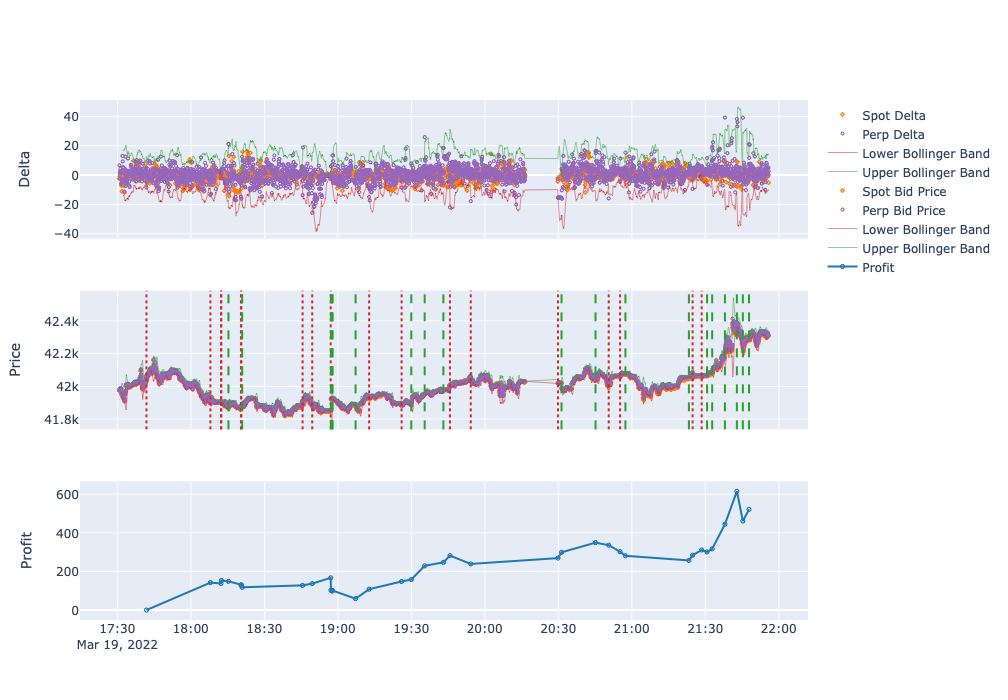

In [14]:
BBAND1_LEN = 20
BBAND2_LEN = 10
STD = 3

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Plot spot and perp deltas
fig.append_trace(go.Scatter(x=df.index, y=df.spot_delta, mode="markers", name="Spot Delta", 
                            marker=dict(color="#ff7f0e", size=3, symbol='cross-open')), row=1, col=1)
fig.append_trace(go.Scatter(x=df.index, y=df.perp_delta, mode="markers", name="Perp Delta", 
                            marker=dict(color="#9467bd", size=3, symbol='circle-open')), row=1, col=1)


# Plot perp delta bollinger bands
perp_delta_bbands = ta.bbands(df["perp_delta"], length=BBAND1_LEN, std=STD)
fig.append_trace(go.Scatter(x=df.index, y=perp_delta_bbands.iloc[:, 0], mode="lines", name="Lower Bollinger Band", 
                            line_color="#d62728", line_width=0.5), row=1, col=1)
fig.append_trace(go.Scatter(x=df.index, y=perp_delta_bbands.iloc[:, 2], mode="lines", name="Upper Bollinger Band", 
                            line_color="#2ca02c", line_width=0.5), row=1, col=1)

# Plot spot and perp bid prices
fig.append_trace(go.Scatter(x=df.index, y=df.spot_bid_price, mode="markers", name="Spot Bid Price", 
                            marker=dict(color="#ff7f0e", size=3, symbol='cross-open')), row=2, col=1)
#fig.append_trace(go.Scatter(x=df.index, y=df.spot_ask_price, mode="markers", name="Spot Ask Price", 
#                            marker=dict(color="red", size=4, symbol='cross-open')), row=2, col=1)
fig.append_trace(go.Scatter(x=df.index, y=df.perp_bid_price, mode="markers", name="Perp Bid Price",
                            marker=dict(color="#9467bd", size=3, symbol='circle-open')), row=2, col=1)
#fig.append_trace(go.Scatter(x=df.index, y=df.perp_ask_price, mode="markers", name="Perp Ask Price",
#                            marker=dict(color="red", size=4, symbol='circle-open')), row=2, col=1)

# Plot perp bid price bollinger bands
perp_bid_price_bbands = ta.bbands(df["perp_bid_price"], length=BBAND2_LEN, std=STD)
fig.append_trace(go.Scatter(x=df.index, y=perp_bid_price_bbands.iloc[:, 0], mode="lines", name="Lower Bollinger Band", 
                            line_color="#d62728", line_width=0.5), row=2, col=1)
fig.append_trace(go.Scatter(x=df.index, y=perp_bid_price_bbands.iloc[:, 2], mode="lines", name="Upper Bollinger Band", 
                            line_color="#2ca02c", line_width=0.5), row=2, col=1)

# Get all entries and exits in a DataFrame, and plot them
df_orders = pd.DataFrame(columns=["time", "bid_price", "ask_price", "position"])
idx = 0
for index in df.index[trigger_conditions(trigger_set=0)]:
    fig.add_vline(x=index, line_dash="dot", row=2, col=1, line=dict(color="#d62728"))
    df_orders.loc[idx] = [index, df.perp_bid_price[index], df.perp_ask_price[index], "short"]
    idx += 1
for index in df.index[trigger_conditions(trigger_set=1)]:
    fig.add_vline(x=index, line_dash="dash", row=2, col=1, line=dict(color="#2ca02c"))
    df_orders.loc[idx] = [index, df.perp_bid_price[index], df.perp_ask_price[index], "long"]
    idx += 1

# Compute profitability and plot result
df_orders = df_orders.set_index("time").sort_index()
fig.append_trace(go.Scatter(x=df_orders.index, y=get_profitability(df_orders), mode="markers+lines", name="Profit", 
                            marker=dict(color="#1f77b4", size=4, symbol='circle-open')), row=3, col=1)

fig.update_yaxes(title_text="Delta", row=1, col=1)
fig.update_yaxes(title_text="Price", row=2, col=1)
fig.update_yaxes(title_text="Profit", row=3, col=1)

fig.update_layout(height=700, width=1200)
fig.show()

# fig.write_image(os.path.join("..", "images", "orderbook_delta_analyzer.png"))
# fig.write_html(os.path.join("..", "images", "orderbook_delta_analyzer.html"))

# Simple Optimizer

Optimize to max profit

In [6]:
import numpy as np
import itertools
from tqdm import tqdm

In [ ]:
bbands_lens = [10, 15, 20, 21, 25, 30]
stds = [2, 2.5, 3, 3.5, 4]

profit = np.zeros(len(bbands_lens) * len(bbands_lens) * len(stds))

iterator = tqdm(itertools.product(bbands_lens, bbands_lens, stds))

for _idx, (bbands_len1, bbands_len2, std) in enumerate(iterator):
    perp_delta_bbands = ta.bbands(df["perp_delta"], length=bbands_len1, std=std)
    perp_bid_price_bbands = ta.bbands(df["perp_bid_price"], length=bbands_len2, std=std)

    df_orders = pd.DataFrame(columns=["time", "bid_price", "ask_price", "position"])
    idx = 0
    for index in df.index[trigger_conditions(trigger_set=0)]:
        df_orders.loc[idx] = [index, df.perp_bid_price[index], df.perp_ask_price[index], "short"]
        idx += 1
    for index in df.index[trigger_conditions(trigger_set=1)]:
        df_orders.loc[idx] = [index, df.perp_bid_price[index], df.perp_ask_price[index], "long"]
        idx += 1

    # Compute profitability and plot result
    df_orders = df_orders.set_index("time").sort_index()

    profits = get_profitability(df_orders)
    if len(profits) == 0:
        profit[_idx] = 0
    else:
        profit[_idx] = profits[-1]

In [ ]:
for _idx, (bbands_len1, bbands_len2, std) in enumerate(itertools.product(bbands_lens, bbands_lens, stds)):
    if _idx == np.argmax(profit):
        print(f"Max profit of {profit[_idx]} at BBAND_LEN=({bbands_len1}, {bbands_len2}), STD={std}")
        break

# Position sizing with Kelly criterion

Position sizing using Kelly criterion

$$ f* = p + \frac{p - 1}{b} $$

where,  
$f*$ is the fraction of the  size of the position to take  
$p$ is the probability of a win  
$b$ is the fraction gained on winning  

We restrict the space to set of values 

$ b \in [1.05, 2] $  
$ p \in [0.1, 1] $

In [49]:
def kelly_size(p: np.ndarray, b: float) -> np.ndarray:
    return p + (p - 1) / b

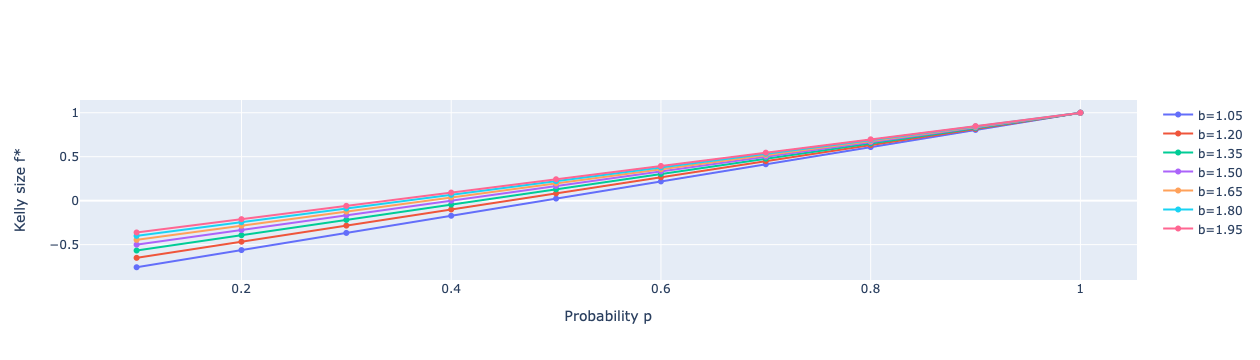

In [48]:
probability = np.linspace(0.1, 1, 10)
fraction_gained = np.arange(1.05, 2, 0.15)

fig2 = go.Figure()
    
for b in fraction_gained:
    fraction = kelly_size(probability, b)
    
    fig2.add_trace(
        go.Scatter(
            x=p, 
            y=fraction, 
            mode="markers+lines", 
            name=f"b={b:.2f}"
        )
    )

# fig2.update_xaxes(type="log")

fig2.update_layout(
    xaxis_title="Probability p",
    yaxis_title="Kelly size f*",
)

fig2.show()